In [ ]:
cimport numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [ ]:
saved_df = pd.read_pickle('/content/driver/My Drive/Data-driven Business/dataset.DataFrame.pkl')

In [ ]:
saved_df['DATE_DIM'] = pd.to_datetime(saved_df['DATE_DIM'])

df_day = saved_df.groupby('DATE_DIM').sum()

column = ['FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS'	]

df_day = df_day[column]

In [ ]:
df_day

,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
DATE_DIM,,,,,,,,
2021-01-01,1738571.55,160299.45,1934394.51,0.0,3833265.51,3112916.78,6.119786e+05,488174
2021-01-02,3326777.95,257613.55,2577236.51,2.0,6161630.01,4946309.51,1.109072e+06,698123
2021-01-03,930568.79,331455.71,935693.19,0.0,2197717.69,1826788.81,3.290612e+05,280655
2021-01-04,586606.57,321698.43,614828.67,183.5,1523317.17,1287324.11,1.996055e+05,194818
2021-01-05,602362.79,224912.71,653174.32,147.5,1480597.32,1213484.66,2.517205e+05,201631
...,...,...,...,...,...,...,...,...
2022-12-27,1122235.00,305708.75,946658.70,0.0,2374602.45,1896714.37,3.869702e+05,307604
2022-12-28,1700374.00,255887.93,1360636.29,0.0,3316898.22,2765449.78,4.989820e+05,425174
2022-12-29,1443438.00,279081.76,1067987.10,385.0,2790891.86,2350240.87,3.684780e+05,358250


In [ ]:
df_day['TOTAL_TURNOVER'] = df_day['TOTAL_TURNOVER'].astype(float)

In [ ]:
df_train = df_day[df_day.index < '2022-10-01']

In [ ]:
df_test = df_day[df_day.index >= '2022-10-01']

In [ ]:
data_train = df_train['TOTAL_TURNOVER'].to_numpy().reshape(-1, 1)
data_test = df_test['TOTAL_TURNOVER'].to_numpy().reshape(-1, 1)

In [ ]:
scaler = StandardScaler()

data_train = scaler.fit_transform(data_train).flatten().tolist()
data_test = scaler.fit_transform(data_test).flatten().tolist()


In [ ]:
SEQUENCE_LENGTH = 60

def to_sequence(length_seq, data):
  x = []
  y = []
  for i in range(len(data) - length_seq):
    window = data[i : (i + length_seq)]
    after_window = data[i + length_seq]
    x.append(window)
    y.append(after_window)

  return torch.tensor(x, dtype=torch.float32).view(-1, length_seq, 1), torch.tensor(y, dtype=torch.float32).view(-1,1)

In [ ]:
x_train, y_train = to_sequence(SEQUENCE_LENGTH, data_train)
x_test, y_test = to_sequence(SEQUENCE_LENGTH, data_test)

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0,1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

In [ ]:
class Transformer(nn.Module):
  def __init__(self, input_dim = 1, d_model = 64, num_head = 4, num_layers = 2, dropout=0.2):
    super(Transformer, self).__init__()

    self.encoder = nn.Linear(input_dim, d_model)
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layers = nn.TransformerEncoderLayer(d_model, num_head)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
    self.decoder = nn.Linear(d_model, 1)

  def forward(self, x):
    x = self.encoder(x)
    x = self.pos_encoder(x)
    x = self.transformer_encoder(x)
    x = self.decoder(x[:, -1, :])

    return x

model = Transformer()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 500
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_losses = []  # List to store training losses for this epoch
    for batch in train_loader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())  # Append the loss for this batch

    # Compute the average training loss for this epoch
    train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/500, Training Loss: 1.8189, Validation Loss: 0.8560
Epoch 2/500, Training Loss: 0.9687, Validation Loss: 0.8664
Epoch 3/500, Training Loss: 0.9532, Validation Loss: 0.8755
Epoch 4/500, Training Loss: 1.0265, Validation Loss: 0.9301
Epoch 5/500, Training Loss: 1.0603, Validation Loss: 0.8391
Epoch 6/500, Training Loss: 1.1776, Validation Loss: 0.8158
Epoch 7/500, Training Loss: 0.9291, Validation Loss: 0.8358
Epoch 8/500, Training Loss: 0.8622, Validation Loss: 0.8870
Epoch 9/500, Training Loss: 1.0111, Validation Loss: 0.8242
Epoch 10/500, Training Loss: 0.8257, Validation Loss: 0.9595
Epoch 11/500, Training Loss: 0.8692, Validation Loss: 0.8416
Epoch 12/500, Training Loss: 0.8038, Validation Loss: 0.8262
Epoch 13/500, Training Loss: 0.8046, Validation Loss: 0.8898
Epoch 14/500, Training Loss: 0.8316, Validation Loss: 0.8717
Epoch 15/500, Training Loss: 0.8202, Validation Loss: 0.8939
Epoch 16/500, Training Loss: 0.7975, Validation Loss: 0.8606
Epoch 17/500, Training Loss: 0.91

In [ ]:
torch.save(model, '/content/driver/My Drive/Data-driven Business/Transformer.pth')

In [ ]:
saved_model = torch.load( '/content/driver/My Drive/Data-driven Business/Transformer.pth')

In [ ]:
import numpy as np

predictions = []
targets = []

# Disable gradient calculation
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        output = model(x_batch)
        predictions.extend(output.flatten().numpy())
        targets.extend(y_batch.numpy())

# Convert to numpy arrays
predictions = np.array(predictions)
targets = np.array(targets)

# Calculate MSE
mse = np.mean((predictions - targets) ** 2)

print(f"Mean Squared Error (MSE) on the test set: {mse:.4f}")


Mean Squared Error (MSE) on the test set: 1.0587


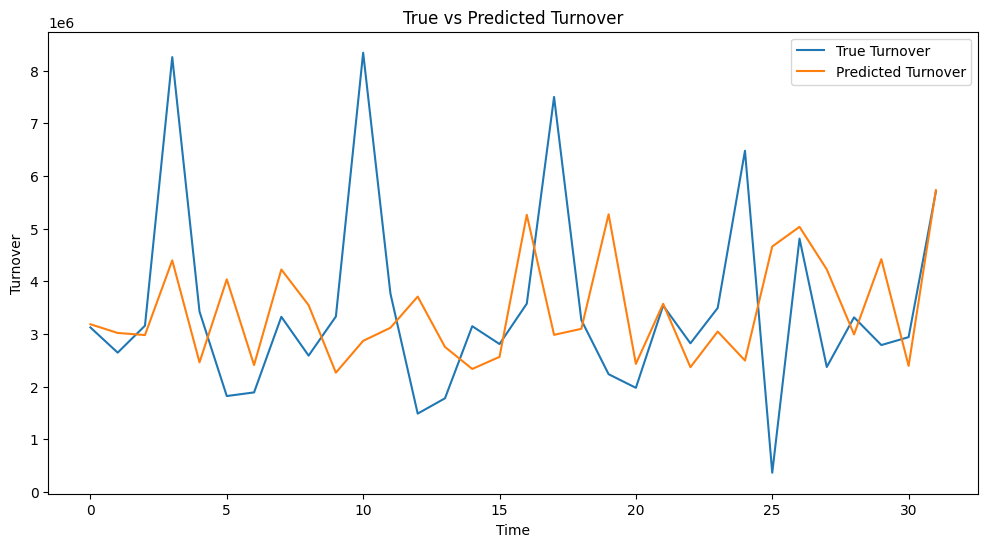

In [ ]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Chuyển dữ liệu kiểm tra trở lại sang tỷ lệ ban đầu
true_values = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()

# Biểu đồ giá trị thực và dự đoán
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Turnover')
plt.plot(predictions, label='Predicted Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.title('True vs Predicted Turnover')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def predict_future(model, input_sequence, future_steps):
    predictions = []
    input_sequence = input_sequence.clone().detach()
    with torch.no_grad():
        for _ in range(future_steps):
            output = model(input_sequence.unsqueeze(0))
            predictions.append(output.item())
            input_sequence = torch.cat((input_sequence[:, 1:, :], output.unsqueeze(1).unsqueeze(2)), dim=1)

future_steps = 10

# Get the last sequence from test data as initial input
initial_input = x_test[-1]

# Predict future values
future_predictions = predict_future(saved_model, initial_input, future_steps)

predicted_values_original_scale = scaler.inverse_transform(future_predictions)

# Plot actual and predicted values
plt.plot(range(len(data_test)), scaler.inverse_transform(data_test), label='Actual')
plt.plot(range(len(data_test), len(data_test) + future_steps), predicted_values_original_scale, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Total Turnover')
plt.title('Actual vs Predicted Future Values')
plt.legend()
plt.show()

IndexError: too many indices for tensor of dimension 2